# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [9]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [4]:
data_m = data.resample('M').mean()

In [19]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2002-01-31 to 2018-08-31
Freq: M
Data columns (total 12 columns):
PJME_MW            200 non-null float64
year               200 non-null float64
month              200 non-null float64
dayofmonth         200 non-null float64
quarter            200 non-null float64
dayofyear          200 non-null float64
weekofyear         200 non-null float64
dayofweek          200 non-null float64
hour               200 non-null float64
is_holiday         200 non-null float64
is_prev_holiday    200 non-null float64
is_next_holiday    200 non-null float64
dtypes: float64(12)
memory usage: 20.3 KB


C:\Users\Kashenkov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


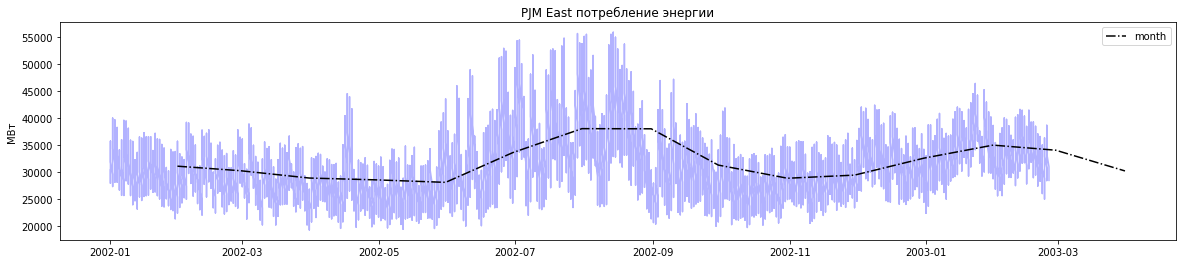

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

In [6]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 26 месяцев
qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs ,26] 

In [7]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 1, 1, 26]


In [10]:
#для построения модели используем все данные, кроме 12-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[0, 1, 1, 26] - AIC:2549.7081486880998


In [11]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 26)   Log Likelihood               -1269.854
Date:                            Wed, 22 Jan 2020   AIC                           2549.708
Time:                                    09:44:52   BIC                           2564.084
Sample:                                         0   HQIC                          2555.550
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

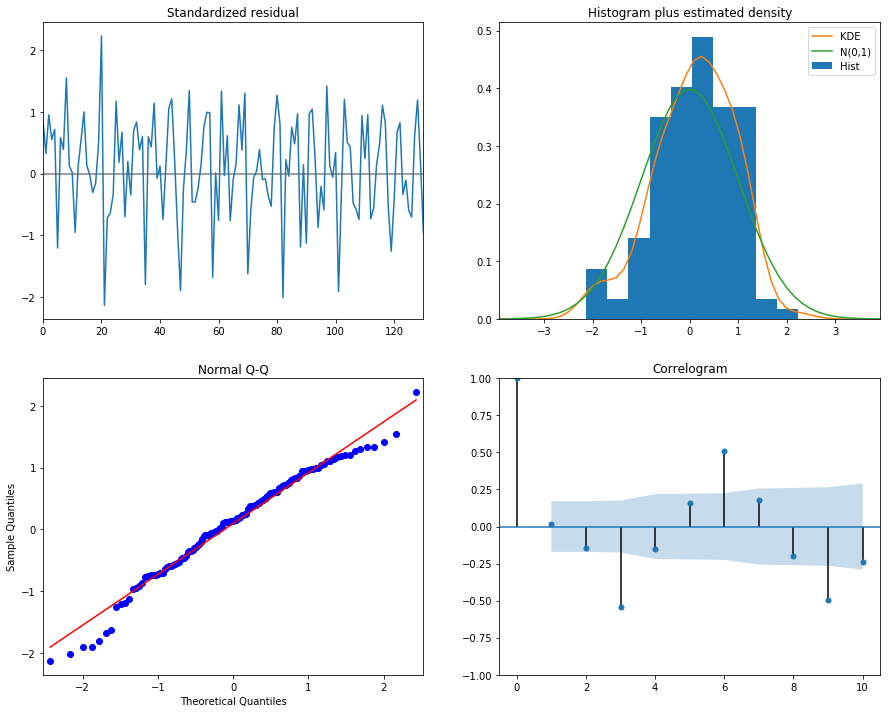

In [12]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [13]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]

In [15]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 26)3 - AIC:3992.5110075928433
ARIMA(0, 0, 0)x(0, 0, 1, 26)3 - AIC:3285.6570594543173
ARIMA(0, 0, 0)x(0, 0, 2, 26)3 - AIC:5164.563399804145
ARIMA(0, 0, 0)x(0, 1, 0, 26)3 - AIC:2879.425251103865
ARIMA(0, 0, 0)x(0, 1, 1, 26)3 - AIC:2339.951891125023
ARIMA(0, 0, 0)x(0, 2, 0, 26)3 - AIC:2484.2063266048976
ARIMA(0, 0, 0)x(0, 2, 1, 26)3 - AIC:1888.47090561337
ARIMA(0, 0, 0)x(1, 0, 0, 26)3 - AIC:2899.327202799901
ARIMA(0, 0, 0)x(1, 0, 1, 26)3 - AIC:2880.0135062256086
ARIMA(0, 0, 0)x(1, 0, 2, 26)3 - AIC:4733.736245335123
ARIMA(0, 0, 0)x(1, 1, 0, 26)3 - AIC:2351.140285803429
ARIMA(0, 0, 0)x(1, 1, 1, 26)3 - AIC:2332.215439889453
ARIMA(0, 0, 0)x(1, 2, 0, 26)3 - AIC:1927.0384944589027
ARIMA(0, 0, 0)x(1, 2, 1, 26)3 - AIC:1899.1945235986532
ARIMA(0, 0, 0)x(2, 0, 0, 26)3 - AIC:2352.194131000001
ARIMA(0, 0, 0)x(2, 0, 1, 26)3 - AIC:2353.0270237702057
ARIMA(0, 0, 0)x(2, 0, 2, 26)3 - AIC:2332.9625150016454
ARIMA(0, 0, 0)x(2, 1, 0, 26)3 - AIC:1735.9925256721667
ARIMA(0, 0, 0)x(2, 1

ARIMA(0, 2, 1)x(0, 1, 1, 26)3 - AIC:2276.384045488271
ARIMA(0, 2, 1)x(0, 2, 0, 26)3 - AIC:2448.1678347196384
ARIMA(0, 2, 1)x(0, 2, 1, 26)3 - AIC:1839.0817231444748
ARIMA(0, 2, 1)x(1, 0, 0, 26)3 - AIC:2723.8902078290025
ARIMA(0, 2, 1)x(1, 0, 1, 26)3 - AIC:2679.031889444726
ARIMA(0, 2, 1)x(1, 0, 2, 26)3 - AIC:4337.715055357429
ARIMA(0, 2, 1)x(1, 1, 0, 26)3 - AIC:2334.777950730794
ARIMA(0, 2, 1)x(1, 1, 1, 26)3 - AIC:2234.4533329300502
ARIMA(0, 2, 1)x(1, 2, 0, 26)3 - AIC:1897.9126586629745
ARIMA(0, 2, 1)x(1, 2, 1, 26)3 - AIC:1834.8872058327588
ARIMA(0, 2, 1)x(2, 0, 0, 26)3 - AIC:2211.5585987721097
ARIMA(0, 2, 1)x(2, 0, 1, 26)3 - AIC:2206.7081267711683
ARIMA(0, 2, 1)x(2, 0, 2, 26)3 - AIC:3715.9634286854384
ARIMA(0, 2, 1)x(2, 1, 0, 26)3 - AIC:1712.4361603281845
ARIMA(0, 2, 1)x(2, 1, 1, 26)3 - AIC:1713.9376000578964
ARIMA(0, 2, 1)x(2, 2, 0, 26)3 - AIC:1328.4079788028992
ARIMA(0, 2, 1)x(2, 2, 1, 26)3 - AIC:1240.454906277802
ARIMA(0, 2, 2)x(0, 0, 0, 26)3 - AIC:3164.6031750667894
ARIMA(0, 2, 2)x

ARIMA(1, 1, 2)x(1, 0, 0, 26)3 - AIC:2649.9349127118003
ARIMA(1, 1, 2)x(1, 0, 1, 26)3 - AIC:2602.1989854077856
ARIMA(1, 1, 2)x(1, 0, 2, 26)3 - AIC:9636.258388922779
ARIMA(1, 1, 2)x(1, 1, 0, 26)3 - AIC:2259.59552050597
ARIMA(1, 1, 2)x(1, 1, 1, 26)3 - AIC:2179.4053774303648
ARIMA(1, 1, 2)x(1, 2, 0, 26)3 - AIC:1841.864972435756
ARIMA(1, 1, 2)x(1, 2, 1, 26)3 - AIC:1728.6598193474636
ARIMA(1, 1, 2)x(2, 0, 0, 26)3 - AIC:2156.6826142133905
ARIMA(1, 1, 2)x(2, 0, 1, 26)3 - AIC:2150.4462965335824
ARIMA(1, 1, 2)x(2, 0, 2, 26)3 - AIC:nan
ARIMA(1, 1, 2)x(2, 1, 0, 26)3 - AIC:1693.7868280022287
ARIMA(1, 1, 2)x(2, 1, 1, 26)3 - AIC:1693.9260043137606
ARIMA(1, 1, 2)x(2, 2, 0, 26)3 - AIC:1241.8072374528542
ARIMA(1, 1, 2)x(2, 2, 1, 26)3 - AIC:1233.710895123348
ARIMA(1, 2, 0)x(0, 0, 0, 26)3 - AIC:3252.358901834961
ARIMA(1, 2, 0)x(0, 0, 1, 26)3 - AIC:2740.0876155726337
ARIMA(1, 2, 0)x(0, 0, 2, 26)3 - AIC:4376.798349175528
ARIMA(1, 2, 0)x(0, 1, 0, 26)3 - AIC:2868.8678421466175
ARIMA(1, 2, 0)x(0, 1, 1, 26)3 - 

ARIMA(2, 1, 0)x(1, 2, 0, 26)3 - AIC:1778.5151227183314
ARIMA(2, 1, 0)x(1, 2, 1, 26)3 - AIC:1768.7715949445012
ARIMA(2, 1, 0)x(2, 0, 0, 26)3 - AIC:2148.6639821388553
ARIMA(2, 1, 0)x(2, 0, 1, 26)3 - AIC:2130.262216104148
ARIMA(2, 1, 0)x(2, 0, 2, 26)3 - AIC:5279.632795648398
ARIMA(2, 1, 0)x(2, 1, 0, 26)3 - AIC:1668.876736575752
ARIMA(2, 1, 0)x(2, 1, 1, 26)3 - AIC:1669.1951261431009
ARIMA(2, 1, 0)x(2, 2, 0, 26)3 - AIC:1219.347800143684
ARIMA(2, 1, 0)x(2, 2, 1, 26)3 - AIC:1206.8167833917248
ARIMA(2, 1, 1)x(0, 0, 0, 26)3 - AIC:3021.7387729036573
ARIMA(2, 1, 1)x(0, 0, 1, 26)3 - AIC:2556.538200449947
ARIMA(2, 1, 1)x(0, 0, 2, 26)3 - AIC:nan
ARIMA(2, 1, 1)x(0, 1, 0, 26)3 - AIC:2668.2732281620047
ARIMA(2, 1, 1)x(0, 1, 1, 26)3 - AIC:2143.034568701415
ARIMA(2, 1, 1)x(0, 2, 0, 26)3 - AIC:2295.0107141799854
ARIMA(2, 1, 1)x(0, 2, 1, 26)3 - AIC:1729.3864118347144
ARIMA(2, 1, 1)x(1, 0, 0, 26)3 - AIC:2556.8576190230306
ARIMA(2, 1, 1)x(1, 0, 1, 26)3 - AIC:2558.53289623657
ARIMA(2, 1, 1)x(1, 0, 2, 26)3 - A

Лучшие результаты на месячных данных параметры модели SARIMA(1,1, 0)x(2, 2, 1, 26) - AIC:1230.207843363313 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).


In [18]:
#для построения модели используем все данные, кроме 30 последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-30],order=[1,1,0],
                                seasonal_order=[2,2,1,26] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 1230.207843363313


Проведем моделирование прогноза на основе найденой SARIMAX[1, 2, 2]x[0, 1, 1, 26] - AIC:14254.36 и модели  SARIMA(0, 0, 1)x(1, 1, 2, 26) для последних 12 дней(и предсказание следующих 30 )  и сравним их с фактом.

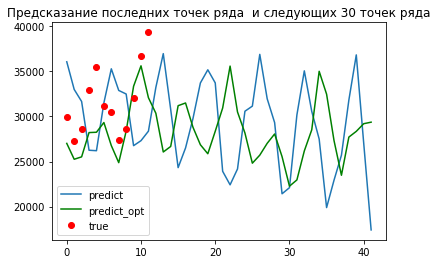

In [22]:
pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

### Выводы

Если сравнить с предсказаниями с недельными, то результат получился намного лучше. Как видно по графику, общий вид совпадает с истиным значением, только в получившейся модели константная составляющая